In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import contractions
import re

In [2]:
data = pd.read_csv("data/train-balanced-sarcasm.csv")

In [3]:
print("Total Number of Entries:",len(data))

Total Number of Entries: 1010826


### Removing Features
author, subreddit, date and created_utc removed for generalizability  
score, ups, downs removed as these values can change with time, and an initial sacarstic comment will have these values set to zero

In [4]:
columns_to_remove = ['author','subreddit','date','created_utc','score','ups','downs']
data_2 = data.drop(columns_to_remove, axis=1)

In [5]:
print(data_2.head())

   label                                            comment  \
0      0                                         NC and NH.   
1      0  You do know west teams play against west teams...   
2      0  They were underdogs earlier today, but since G...   
3      0  This meme isn't funny none of the "new york ni...   
4      0                    I could use one of those tools.   

                                      parent_comment  
0  Yeah, I get that argument. At this point, I'd ...  
1  The blazers and Mavericks (The wests 5 and 6 s...  
2                            They're favored to win.  
3                         deadass don't kill my buzz  
4  Yep can confirm I saw the tool they use for th...  


### Searching for unusable text  
Some comments are NA  
Some comments have only numerical values which could possibly indicate the comment id

In [6]:
# Searching for NA values
print(data_2[data_2["label"].isna()].head())
print("Number of NA labels:",len(data_2[data_2["label"].isna()]))
print()
print(data_2[data_2["comment"].isna()].head())
print("Number of NA text in comment:",len(data_2[data_2["comment"].isna()]))
print()
print(data_2[data_2["parent_comment"].isna()].head())
print("Number of NA text in parent comment:",len(data_2[data_2["parent_comment"].isna()]))

Empty DataFrame
Columns: [label, comment, parent_comment]
Index: []
Number of NA labels: 0

        label comment                                     parent_comment
56269       1     NaN  LPL shitshow, EU LCS shitshow. What isn't a sh...
68590       1     NaN  Car fires smell delicious to you? You should p...
135348      0     NaN                                 Will do. EU or NA?
199910      0     NaN                                      woah, thanks.
258718      1     NaN  No, doing drugs while forming a fetus (your ki...
Number of NA text in comment: 53

Empty DataFrame
Columns: [label, comment, parent_comment]
Index: []
Number of NA text in parent comment: 0


In [7]:
# Removing comments with NA values
data_2 = data_2[~data_2["comment"].isna()]
print("Total Number of Entries after removing NA:", len(data_2))

Total Number of Entries after removing NA: 1010773


In [8]:
# Searching for entries that are just numerical values
rows_with_numbers = data_2[data_2['comment'].apply(lambda x: x.isdigit())]
print(rows_with_numbers.head())
print("Number of rows with comments as digits:", len(rows_with_numbers))
print()
rows_with_numbers_parent = data_2[data_2['parent_comment'].apply(lambda x: x.isdigit())]
print(rows_with_numbers_parent.head())
print("Number of rows with parent_comments as digits:", len(rows_with_numbers_parent))


      label  comment           parent_comment
25        0      466        467 A lovely way!
42        0  1571049                1,571,048
1218      0        4      sv_timebetweenducks
1631      0        7  Is this for gen 6 or 7?
2190      0      412              IA brother?
Number of rows with comments as digits: 530

       label                               comment parent_comment
4993       0                      That's so fetch.             42
5444       0                     Car mechanic 2015          14373
6743       0                                     5              7
7007       0  You can't even see who the faces are           2016
15687      1                                Years?              5
Number of rows with parent_comments as digits: 172


In [9]:
# Removing digit entries
data_3 = data_2[~data_2['comment'].apply(lambda x: x.isdigit())]
data_3 = data_3[~data_3['parent_comment'].apply(lambda x: x.isdigit())]
print("Total Number of Entries after removing NA:", len(data_3))

Total Number of Entries after removing NA: 1010121


### Reducing Size of Dataset
Too many entries of slightly above a million, processing time can become too long for feature engineering and model training

Total Number of Entries before reduction: 1010121
Distribution of Labels
1    505291
0    504830
Name: label, dtype: int64


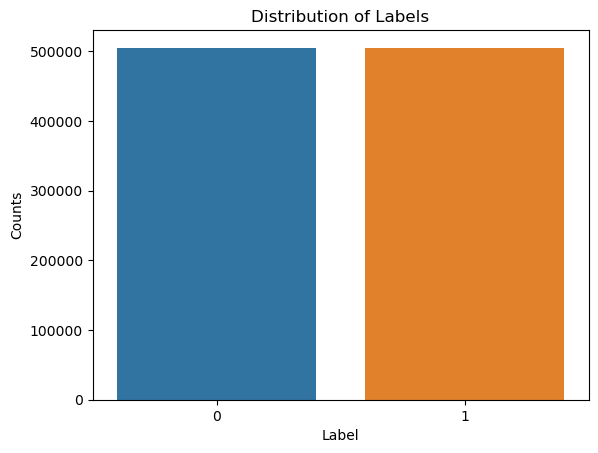

In [10]:
sns.countplot(data_3, x = "label")
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Counts")

print("Total Number of Entries before reduction:",len(data_3))
print("Distribution of Labels")
print(data_3["label"].value_counts())


Original dataset is balanced, can proceed to reduce dataset with stratified sampling to maintain label ratios

In [11]:
# Using stratified 
X = data_3.drop('label', axis = 1)
y = data_3['label']
X_sample, _, y_sample, _ = train_test_split(X, y, test_size = 0.8, stratify = y, random_state = 42)
data_reduced = pd.concat([X_sample,y_sample], axis = 1)
data_reduced = data_reduced.reset_index()
data_reduced.drop('index', axis = 1, inplace = True)

Total Number of Entries after reduction: 202024
Distribution of Labels
1    101058
0    100966
Name: label, dtype: int64


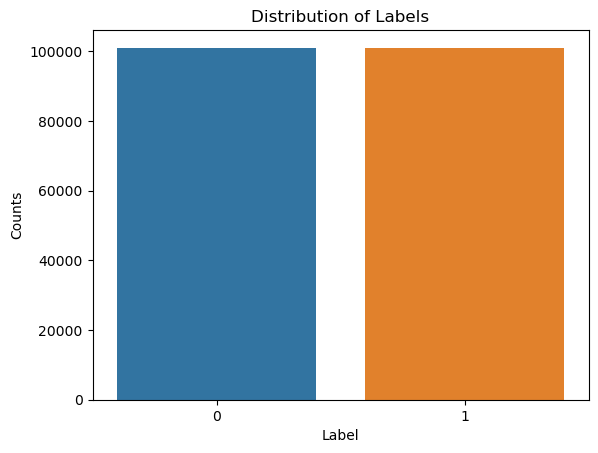

In [12]:
sns.countplot(data_reduced, x = "label")
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Counts")

print("Total Number of Entries after reduction:",len(data_reduced))
print("Distribution of Labels")
print(data_reduced["label"].value_counts())

### Further Data Cleaning
Remove contractions, change to lower case, remove links, usernames and emails

In [13]:
#removing contractions
data_reduced['comment'] = data_reduced['comment'].apply(contractions.fix)
data_reduced['parent_comment'] = data_reduced['parent_comment'].apply(contractions.fix)

In [14]:
#change to lower case
data_reduced['comment'] = data_reduced["comment"].apply(lambda text:text.lower())
data_reduced['parent_comment'] = data_reduced["parent_comment"].apply(lambda text:text.lower())

In [15]:
#function to remove links from text
def remove_links(text):
    text_1 = re.sub(r"[(+*)]\S*https?:\S*[(+*)]", "", text)
    text_2 = re.sub('http://\S+|https://\S+', " ", text_1)
    text_3 = re.sub(r"[\(\[].*?[\)\]]", " ", text_2)
    return text_3

#function to remove email addresses
def remove_emails(text):
    text_1 = re.sub(r'\S+@\S+', '', text)
    return text_1

#function to remove usernames
def remove_usernames(text):
    text_1 = re.sub(r'@\w+', '', text)
    return text_1

def remove_links_emails_usernames(text):
    text_1 = remove_links(text)
    text_2 = remove_emails(text_1)
    text_3 = remove_usernames(text_2)
    return text_3

#removing links, emails and usernames
data_reduced['comment'] = data_reduced['comment'].apply(remove_links_emails_usernames)
data_reduced['parent_comment'] = data_reduced['parent_comment'].apply(remove_links_emails_usernames)

In [19]:
data_reduced.to_pickle("data/data_cleaned.pkl")